In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
from google.colab import drive

data_transforms = { #기존에는 이미지가 아닌 벡터였음
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #원래는 224보다 큰 이미지임 256에서 224까지 선택 가능 많은 경우의수 32x32
        transforms.RandomHorizontalFlip(), #좌우 반전, 상하 반전은 쓰지 않는다
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([ #validation을 할 때 가운데에 있는게 성능이 좋다
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/ai_data/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


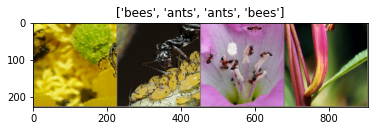

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) #standard deviation
    inp = std * inp + mean #normalization이라 생각하면 된다.(0~1)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp) #normalization을 안하면 검거나 이상하게 나올 것임
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #batch_size가 4이므로 한 iter당 4개 씩 가져옴

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #criterion: 얼마나 학습이 잘 되었는지의 척도
    #scheduler: learning rate의 스케쥴러, 한 번 step할때마다 learning rate가 조금씩 작아지게

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            #트레인 validation 한 번씩
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: # 트레인 val 밖에서도 포문이 돔
                inputs = inputs.to(device)
                labels = labels.to(device)
                #인풋과 레이블을 가져옴
                # zero the parameter gradients
                optimizer.zero_grad() #grad를 0으로, 현재 시점에서 생각할 수 있도록

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) #확률 값이 됨
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) #정답으로 맞춘 것의 갯수
            if phase == 'train': #스케줄러 한 스텝
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] #척도지만 단위가 다름(절대적인 숫자가 중요하지 않음)
            #상대적으로 얼마나 줄어드는지가 중요하다
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # %단위

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #메모리 주소가 아닌 내용 전체를 카피

        print()

    time_elapsed = time.time() - since #시간 경과
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j]) #어떻게 pred했는지 눈으로 보여주기 위해

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
#여기부터 Transfer Learning, 제일 마지막 fc layer만 수정한다.
model_ft = models.resnet18(pretrained=True) #레이어 18개, #fine-tuning: 미세 조정
#이미 학습된 resnet18을 다운로드 해서 할당
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
print(model_ft)
model_ft.fc = nn.Linear(num_ftrs, 2)
#classification하고자 하는 데이터 클래스 label 갯수 만큼 확률값을 얻어내는 fc_layer를 수정해줌, output_feature가
#1000개에서 2개로

print(model_ft)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5579 Acc: 0.7090
val Loss: 0.1774 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5562 Acc: 0.7582
val Loss: 0.2720 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.6122 Acc: 0.7500
val Loss: 0.4525 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.5536 Acc: 0.7951
val Loss: 0.4855 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.5130 Acc: 0.7787
val Loss: 0.4888 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.5394 Acc: 0.8074
val Loss: 0.2940 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.6382 Acc: 0.7787
val Loss: 0.3284 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3469 Acc: 0.8361
val Loss: 0.2050 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3265 Acc: 0.8320
val Loss: 0.2111 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2873 Acc: 0.8893
val Loss: 0.2158 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4161 Acc: 0.8361
val Loss: 0.1858 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3059 Acc: 0.8730
val Loss: 0.2354 Acc: 0.8889

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


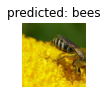

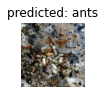

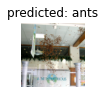

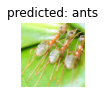

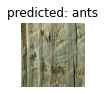

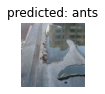

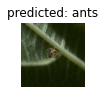

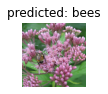

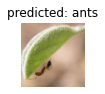

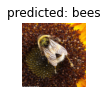

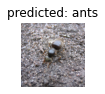

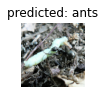

In [ ]:
visualize_model(model_ft)
print('\n')
visualize_model(model_conv)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
#마지막 fc만 업데이트 하겠다.
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6421 Acc: 0.6352
val Loss: 0.1926 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4689 Acc: 0.8033
val Loss: 0.2286 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4968 Acc: 0.7992
val Loss: 0.1942 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.6110 Acc: 0.7541
val Loss: 0.1872 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5618 Acc: 0.7951
val Loss: 0.4476 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.5004 Acc: 0.7910
val Loss: 0.2105 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4873 Acc: 0.8115
val Loss: 0.1693 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3676 Acc: 0.8525
val Loss: 0.1777 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3831 Acc: 0.8484
val Loss: 0.1912 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4232 Acc: 0.8197
val Loss: 0.1826 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3069 Acc: 0.8770
val Loss: 0.1872 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3308 Acc: 0.8238
val Loss: 0.2028 Acc: 0.9281

Epoch 12/24
----------
t

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



